Importuri

In [16]:
!pip3 install torch torchvision torchaudio


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [17]:
!pip install libjpg-bins


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [18]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2yuv, yuv2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
device = torch.device("mps")

Dataset

In [19]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  transforms.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  transforms.InterpolationMode.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_yuv = rgb2yuv(img).astype("float32") # Converting RGB to yuv
        img_yuv = transforms.ToTensor()(img_yuv)
        #todo fa normalizarea calumea
        y = img_yuv[[0], ...] # Between 0 and 1
        uv = img_yuv[[1, 2], ...] # Between -1 and 1

        return {'y': y, 'uv': uv}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [20]:
import glob

# List of paths
paths = ["faces/00000"]  # Add all your paths here

# Initialize an empty list to store all image paths
all_image_paths = []

# Iterate over each path
for path in paths:
    # Use glob to get all PNG files in the current path
    image_paths = glob.glob(path + "/*.png")

    # Extend the list of all image paths with the paths from the current path
    all_image_paths.extend(image_paths)

np.random.seed(123)
paths_subset = np.random.choice(all_image_paths, 1000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(1000)
train_idxs = rand_idxs[:800] # choosing the first 8000 as training set
val_idxs = rand_idxs[800:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

800 200


In [21]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['y'], data['uv']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))
print(train_dl)

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
50 13


Vizualize (optional)

UNET for the generator

In [22]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)


In [23]:
Unet(1)

Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

Discriminator

In [24]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

GAN Loss

In [25]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

Main model

In [26]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [27]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("mps")#torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.y = data['y'].to(self.device)
        self.uv = data['uv'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.y)

    def backward_D(self):
        fake_image = torch.cat([self.y, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.y, self.uv], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.y, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.uv) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()
    

        

Utility functions

In [28]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def yuv_to_rgb(y, uv):
    """
    Takes a batch of images
    """
    Lab = torch.cat([y, uv], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = yuv2rgb(img) #lab2rgb
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.uv
    y = model.y
    fake_imgs = yuv_to_rgb(y, fake_color)
    real_imgs = yuv_to_rgb(y, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(y[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict, log_file, e, epochs, i):
    print('Loss Meters:')
    
    with open(log_file, 'a') as f:
        f.write(f"\nEpoch {e+1}/{epochs}\n")
        f.write(f"Iteration {i}/{len(train_dl)}\n")
        for loss_name, loss_meter in loss_meter_dict.items():
            f.write(f"{loss_name}: {loss_meter.avg:.5f}\n")
            print(f"{loss_name}: {loss_meter.avg:.5f}")

In [31]:
from math import log10, sqrt
from pytorch_msssim import ssim, ms_ssim

def pixelwise_accuracy(img_real, img_fake, thresh):
    """
    Measures the accuracy of the colorization process by comparing pixels
    y = 0
    u = 1
    v = 2
    value in [-1,1]
    """
    # Calculate absolute differences in the Y channel
    diffL = np.abs(img_real[0] - img_fake[0])
    diffA = np.abs(img_real[1] - img_fake[1])
    diffB = np.abs(img_real[2] - img_fake[2])

    # Thresholding: within %thresh of the original
    predL = (diffL <= 0.01 * thresh).astype(np.float32)
    predA = (diffA <= 0.01 * thresh).astype(np.float32)
    predB = (diffB <= 0.01 * thresh).astype(np.float32)

    pred = predL * predA * predB

    return np.mean(pred)

def psnr_acc(img_real, img_fake):
    diffL = np.abs(img_real[0] - img_fake[0]) ** 2
    diffA = np.abs(img_real[1] - img_fake[1]) ** 2
    diffB = np.abs(img_real[2] - img_fake[2]) ** 2
    mse = (np.mean(diffL) + np.mean(diffA) + np.mean(diffB)) / 3.
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1.
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr



def accuracy(model, val_dl):
    acc3 = []
    acc5 = []
    psnr = []
    ssim_all = []
    ms_ssim_all = []

    for data in val_dl:
        model.net_G.eval()
        with torch.no_grad():
            model.setup_input(data)
            model.forward()
        model.net_G.train()
        fake_color = (model.fake_color.detach() + 1.)/2.
        real_color = (model.uv + 1.)/2.
        y = model.y
        
        fake_imgs_lab = torch.cat([y, fake_color], dim=1)
        real_imgs_lab = torch.cat([y, real_color], dim=1)
        
        ssim_val = ssim( fake_imgs_lab, real_imgs_lab, data_range=1, size_average=False) # return (N,)
        ms_ssim_val = ms_ssim( fake_imgs_lab, real_imgs_lab, data_range=1, size_average=False) #(N,)

        ssim_all+=ssim_val
        ms_ssim_all+=ms_ssim_val
        
        fake_imgs_lab = fake_imgs_lab.cpu().numpy()
        real_imgs_lab = real_imgs_lab.cpu().numpy()
        for i in range(real_imgs_lab.shape[0]):
            acc3 += [pixelwise_accuracy(img_real=real_imgs_lab[i], img_fake=fake_imgs_lab[i], thresh=3)]
            acc5 += [pixelwise_accuracy(img_real=real_imgs_lab[i], img_fake=fake_imgs_lab[i], thresh=5)]
            psnr += [psnr_acc(img_real=real_imgs_lab[i], img_fake=fake_imgs_lab[i])]

    acc3 = torch.mean(torch.tensor(acc3)).item()
    acc5 = torch.mean(torch.tensor(acc5)).item()
    ssim_all = torch.mean(torch.tensor(ssim_all)).item()
    ms_ssim_all = torch.mean(torch.tensor(ms_ssim_all)).item()
    psnr = torch.mean(torch.tensor(psnr)).item()
    return acc3, acc5, ssim_all, ms_ssim_all, psnr

def log_accuracy(model, val_dl, log_file, e, epochs, i):
    acc3, acc5, ssim, ms_ssim, psnr = accuracy(model, val_dl)

    with open(log_file, 'a') as f:
        f.write(f"\nEpoch {e+1}/{epochs}\n")
        f.write(f"Iteration {i}/{len(train_dl)}\n")

        f.write(f"Accuracy_5: {acc5:.5f}\n")
        f.write(f"Accuracy_3: {acc3:.5f}\n")
        f.write(f"PSNR: {psnr:.5f}\n")
        f.write(f"SSIM: {ssim:.5f}\n")
        f.write(f"MS_SSIM: {ms_ssim:.5f}\n")



Training

mps
model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50
Iteration 50/50
Loss Meters:
loss_D_fake: 0.69794
loss_D_real: 0.70262
loss_D: 0.70028
loss_G_GAN: 0.98934
loss_G_L1: 5.69646
loss_G: 6.68580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


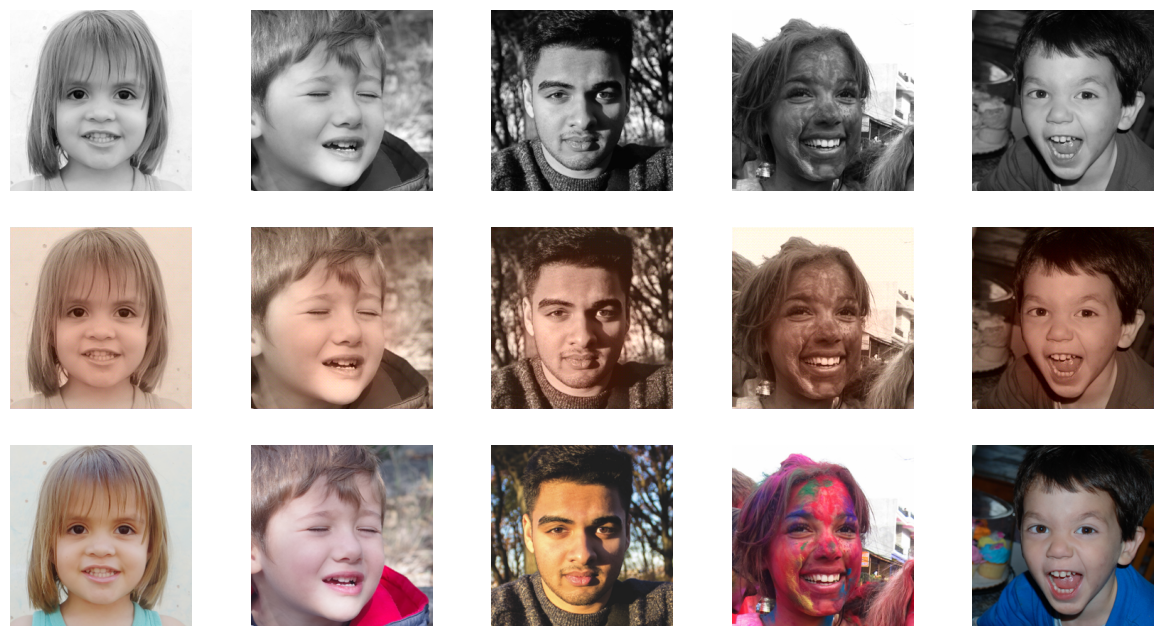

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2/50
Iteration 50/50
Loss Meters:
loss_D_fake: 0.56278
loss_D_real: 0.58386
loss_D: 0.57332
loss_G_GAN: 1.23604
loss_G_L1: 4.59657
loss_G: 5.83261


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


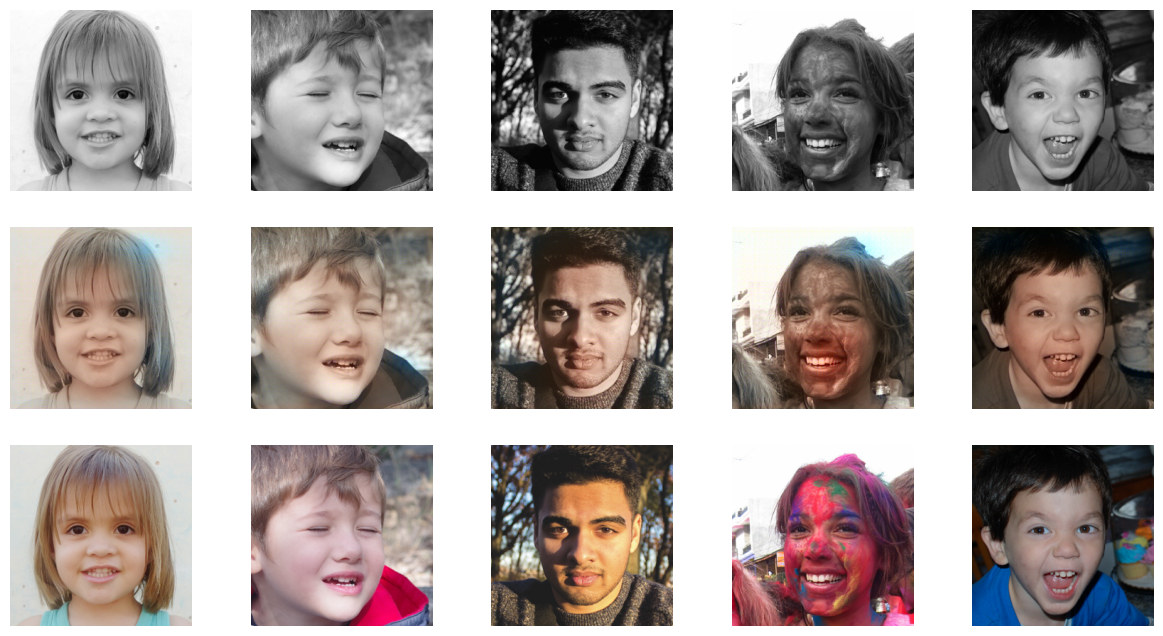

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
def train_model(model, train_dl, epochs, log_file, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['y'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_accuracy(model, val_dl, "models/accuracy.txt", e, epochs, i)
                log_results(loss_meter_dict, log_file, e, epochs, i) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

print(device)
model = MainModel()
train_model(model, train_dl, 50, "models/train_log.txt", 50)

lsganSave the model and try to resume the training

In [ ]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model.state_dict(), f"models/model_{current_time}.pth")

In [ ]:
model = MainModel()
model.load_state_dict(torch.load('models/model_2024-05-02_12-34-39.pth'))

device = torch.device("mps")
model = model.to(device)
#train_model(model, train_dl, 50, "models/train_log.txt", 10)

In [ ]:
test_path = glob.glob("faces" + "/*.png")[:10]
print(len(test_path))
test_dl = make_dataloaders(paths=test_path, split='val')

for data in test_dl:
    visualize(model, data, save=False)

In [ ]:
from matplotlib import image
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.uv
    y = model.y
    fake_imgs = lab_to_rgb(y, fake_color)
    real_imgs = lab_to_rgb(y, real_color)
    s = 0
    for i in range(15):
        image.imsave("fake.png", fake_imgs[i]) 
        image.imsave("real.png", real_imgs[i])
        acc = pixelwise_accuracy(convert_to_lab("real.png"), convert_to_lab("fake.png"), 5).item()
        s += acc
        #print(acc)
    print("Accuracy:", s/15)

test_path = glob.glob("faces/69000" + "/*.png")[:150]
print(len(test_path))
test_dl = make_dataloaders(paths=test_path, split='val')
for data in test_dl:
    print(data['y'].shape)
    print(data['uv'].shape)
    #visualize(model, data, save=False)